In [4]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [7]:
#first get shuffled population
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
fpf.generate_shuffle_population(mice=mice, proj_folder= "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq", total_number_shuffles= 100000, mice_sep=True, use_slurm=False)


TypeError: get_shuffles_mice_sep() got an unexpected keyword argument 'cubelet_cols'

In [2]:
#make fig of shuffle correlations
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, dummy_data=False, IT_only=True)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col != 'Contra':
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    #combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
    
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    #matrix = combined_matrix[cols]
    # matrix= combined_matrix[
    #     combined_matrix[cols].astype(bool).sum(axis=1) > 0
    # ].reset_index(drop=True) #only look at neurons projecting to HVAs
    all_combined[key] = combined_matrix

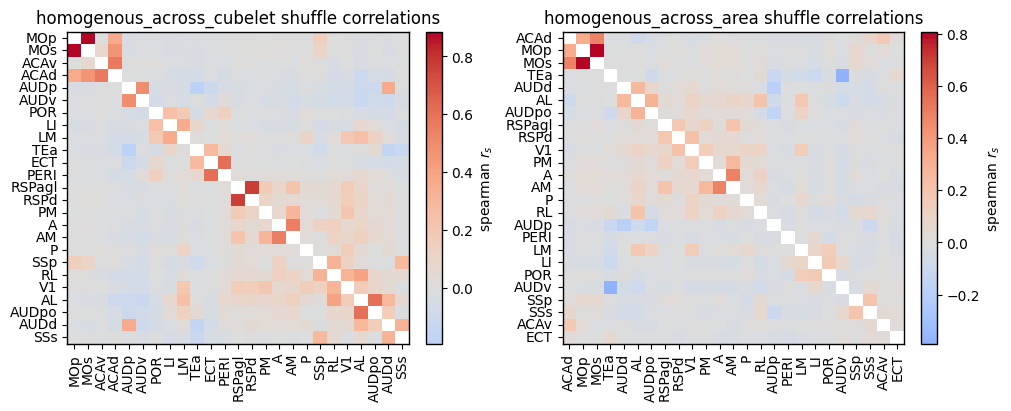

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout = True)
for i, key in enumerate(['homogenous_across_cubelet', 'homogenous_across_area']):
    matrix = all_combined[key]
    cluster = sb.clustermap(data=matrix.corr(method='spearman'), row_cluster=True,    # Keep clustering on rows
        col_cluster=True, )
    plt.close(cluster.fig)
    row_order = cluster.dendrogram_row.reordered_ind
    row_labels = [cluster.data.index[i] for i in row_order]
    reordered_mat = matrix[row_labels].corr(method ='spearman')
    np.fill_diagonal(reordered_mat.values, np.nan)
    sb.heatmap(ax=axs[i], data=fpf.convert_matrix_names(reordered_mat), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    axs[i].set_title(f'{key} shuffle correlations')
    for _, spine in axs[i].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

Liklihood/chance approach

In [8]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False, IT_only=True)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

ValueError: Axis limits cannot be NaN or Inf

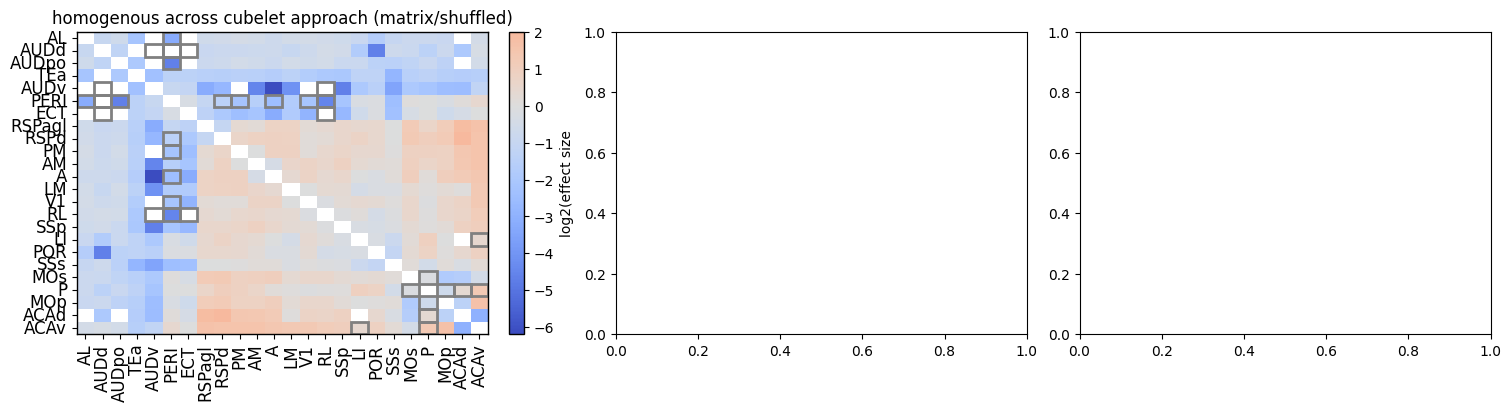

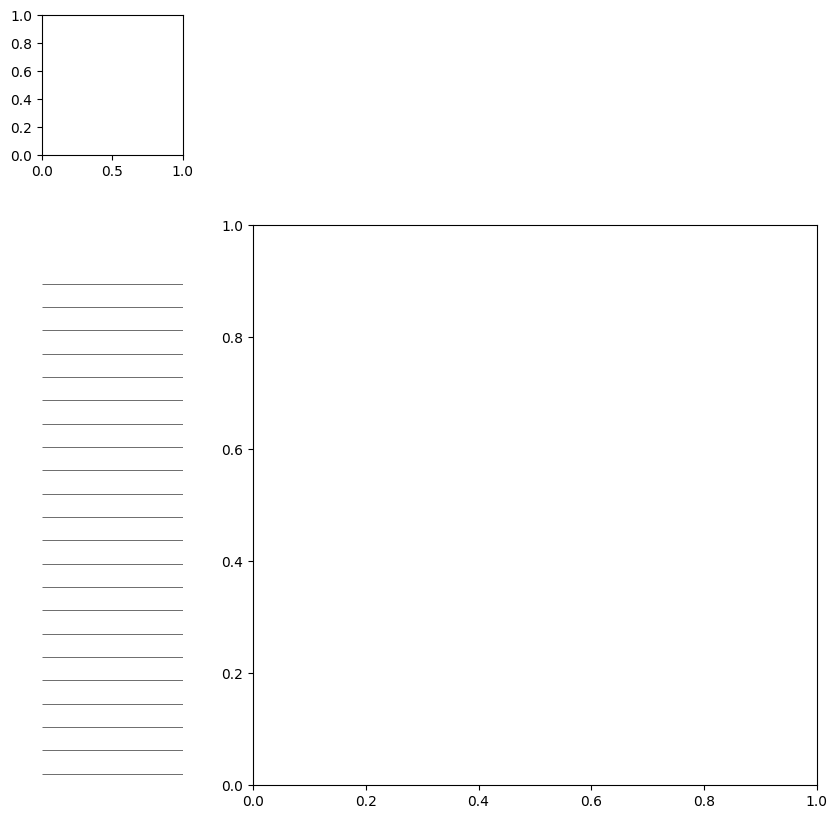

In [14]:
analysis = ['cubelet', 'area', 'main']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
p_value_dict = {}
mean_value_dict = {}
cond_prob_dict_both = {}
cond_prob_dict_both_shuffled = {}
for number, key in enumerate(['cubelet', 'area']):
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    conditional_prob = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for index, r in conditional_prob.iterrows():
        for column in cols_reordered:
            prob_df = pd.DataFrame()
            prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
            prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            if index ==column:
                conditional_prob.loc[index, column] = np.nan
            else:
                conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))
    cond_prob_dict_both[key]=conditional_prob
    
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    conditional_prob_matrix = pd.DataFrame()
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        try:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = np.nan
        try:    
            conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[1], separated_words[0]] = np.nan
    for column_name in conditional_prob_matrix.columns:
        mean_cond_prob = conditional_prob_matrix[column_name].mean()
        if column_name[0] in cols_reordered and column_name[1] in cols_reordered:
            mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
            val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
            if val_to_comp >= mean_cond_prob:
                #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cond_prob:
                #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[column_name[0], column_name[1]] = p_val
        #p_val_matrix.loc[column_name[1], column_name[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols_reordered)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
   

fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout = True)
analysis_names =['cubelet', 'area', 'main']
for where_to_put, key in enumerate(analysis_names):
    if key in ('cubelet', 'area'):
        p_val_matrix = p_value_dict[key]
        #for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        comparison =np.log2(compare_matrices[0])/(compare_matrices[1])
        cols_with_any_inf = np.isinf(comparison).all(axis=0)
        df = comparison.loc[:, ~cols_with_any_inf]
        to_clust = df.copy()
        to_clust = to_clust.replace(np.nan, 0)
        cluster = sb.clustermap(data=to_clust, row_cluster=True,    # Keep clustering on rows
        col_cluster=True, )
        plt.close(cluster.fig)
        row_order = cluster.dendrogram_row.reordered_ind
        row_labels = [cluster.data.index[i] for i in row_order]
        new_df_reordered = df.loc[row_labels, row_labels]
        to_plot = fpf.convert_matrix_names(np.log2(new_df_reordered))
        to_plot.replace([np.inf, -np.inf], np.nan, inplace=True)
        axs[where_to_put].set_title(f'homogenous across {key} approach (matrix/shuffled)')
    
    elif key == 'main':
        all_cols = all_combined[f'area_is_{key}'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        conditional_prob = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for index, r in conditional_prob.iterrows():
            for column in cols_reordered:
                prob_df = pd.DataFrame()
                prob_df["a"] = all_combined[f'area_is_{key}'][column].astype(bool)
                prob_df["b"] = all_combined[f'area_is_{key}'][index].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                if index ==column:
                    conditional_prob.loc[index, column] = np.nan
                else:
                    conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'area_is_{key}'])*(prob_df["b"].sum()/len(all_combined[f'area_is_{key}']))*len(all_combined[f'area_is_{key}']))))
            to_clust = conditional_prob.copy()
            to_clust=to_clust
            to_clust = to_clust.replace(np.nan, 0)
            cluster = sb.clustermap(data=to_clust, row_cluster=True,    # Keep clustering on rows
            col_cluster=True, metric='canberra')
            plt.close(cluster.fig)
            row_order = cluster.dendrogram_row.reordered_ind
            row_labels = [cluster.data.index[i] for i in row_order]
            new_df_reordered = conditional_prob.loc[row_labels, row_labels]
            to_plot = fpf.convert_matrix_names(np.log2(new_df_reordered))
            #to_plot = np.log2(conditional_prob)
            #to_plot =fpf.convert_matrix_names(to_plot)
            axs[where_to_put].set_title(f'area is main approach')
    sb.heatmap(ax=axs[where_to_put], data =to_plot, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size'})
    for _, spine in axs[where_to_put].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
    
    # axs[where_to_put].set_xlabel('Area B')
    # axs[where_to_put].set_ylabel('Area A')
    axs[where_to_put].tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs[where_to_put].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    if key in ('cubelet', 'area'):
        for ii in compare_matrices[0].columns:
            for j in compare_matrices[0].columns:
                if p_val_matrix.loc[ii, j] > 0.05:
                    row_idx = new_df_reordered.index.get_loc(ii)  # get the index of the row name
                    col_idx = new_df_reordered.columns.get_loc(j)  
                    axs[where_to_put].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))


In [10]:
new_df_reordered

,ACAv,SSs,PERI,ECT,VISal,AUDd,AUDpo,TEa,AUDv,VISpl,...,VISli,VISpor,RSPagl,RSPd,VISpm,VISam,VISa,MOp,ACAd,MOs
ACAv,NaN,2.308860,2.703884,1.952064,2.217090,1.963998,1.941628,1.420153,1.515735,4.734173,...,2.890653,3.476050,6.250306,5.803561,6.118552,5.835133,5.427647,9.267600,1.251165,2.595975
SSs,2.308860,NaN,1.286850,1.262189,1.428426,1.358102,1.413368,1.245663,1.156073,1.741201,...,1.738908,1.536837,2.040547,2.073761,2.078676,2.203232,2.236233,2.216499,1.829876,2.234401
PERI,2.703884,1.286850,NaN,1.573289,1.039959,0.947635,1.061847,1.347019,1.384941,1.938898,...,1.891083,1.767584,1.411671,1.275781,1.175352,1.264319,1.180810,1.935144,2.788850,2.142590
ECT,1.952064,1.262189,1.573289,NaN,1.154014,0.992400,1.125374,1.332399,1.449170,2.095982,...,1.873262,1.885900,1.504799,1.392316,1.294991,1.344910,1.228686,1.614561,1.622392,1.784119
VISal,2.217090,1.428426,1.039959,1.154014,NaN,1.312357,1.310200,1.265075,1.065429,1.323922,...,1.415637,1.353955,1.500799,1.458367,1.569355,1.516554,1.480105,1.521598,2.491661,1.566595
AUDd,1.963998,1.358102,0.947635,0.992400,1.312357,NaN,1.264123,1.142504,1.035962,1.294171,...,1.413305,1.167199,1.482316,1.472321,1.500377,1.517566,1.557543,1.594214,1.684931,1.565181
AUDpo,1.941628,1.413368,1.061847,1.125374,1.310200,1.264123,NaN,1.261594,1.073942,1.383362,...,1.493921,1.425895,1.480677,1.461386,1.587480,1.528419,1.497263,1.402784,1.696674,1.424643
TEa,1.420153,1.245663,1.347019,1.332399,1.265075,1.142504,1.261594,NaN,1.235469,1.454002,...,1.393899,1.419209,1.411012,1.404627,1.422945,1.410136,1.383488,1.405409,1.416391,1.421966
AUDv,1.515735,1.156073,1.384941,1.449170,1.065429,1.035962,1.073942,1.235469,NaN,1.316882,...,1.323164,1.420543,1.226299,1.258204,1.153007,1.185389,1.164144,1.292774,1.310263,1.359760
VISpl,4.734173,1.741201,1.938898,2.095982,1.323922,1.294171,1.383362,1.454002,1.316882,NaN,...,3.625540,3.368747,3.337090,4.328631,3.741866,3.032777,2.161826,1.607574,3.924321,1.939455


In [3]:
mean_cond_prob

NameError: name 'mean_cond_prob' is not defined

In [4]:
key = 'area'
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)

In [5]:
shuffled_2_combinations

,"VISam, ACAd","VISam, AUDv","VISam, SSs","VISam, SSp","VISam, RSPd","VISam, ECT","VISam, RSPagl","VISam, HPF","VISam, PERI","VISam, VISpor",...,"MOp, AUDpo","MOp, VISp","MOp, VISpl","MOp, ACAv","AUDpo, VISp","AUDpo, VISpl","AUDpo, ACAv","VISp, VISpl","VISp, ACAv","VISpl, ACAv"
0,5,378,164,121,55,176,229,144,77,232,...,140,39,13,1,408,113,5,66,1,1
1,11,338,132,134,50,187,229,131,64,247,...,120,41,11,0,404,108,6,67,4,1
2,6,357,166,139,40,182,225,146,72,237,...,134,41,12,0,403,101,4,65,3,2
3,4,359,150,134,53,198,237,142,68,250,...,132,30,16,0,422,108,6,66,3,0
4,6,337,155,138,52,179,221,141,82,261,...,140,43,12,1,403,110,8,63,3,1
5,6,333,130,134,48,188,231,139,66,230,...,126,42,10,0,407,115,11,65,2,0
6,3,344,156,115,49,184,223,134,73,228,...,133,39,8,1,391,104,6,60,3,1
7,6,346,121,137,56,205,238,134,71,254,...,130,38,15,0,395,107,4,62,1,0
8,5,348,142,121,54,179,235,150,69,239,...,129,42,15,1,387,106,10,68,0,0
9,8,339,135,126,39,173,224,141,66,232,...,134,40,12,2,398,103,4,70,1,0


In [74]:
shuffled_2_combinations['SSp, ACAv']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
195      3
196      2
197      2
198      4
199      1
Name: SSp, ACAv, Length: 200, dtype: object

In [6]:
shuffled_2_combinations.columns[shuffled_2_combinations.isna().any()].tolist()

[]

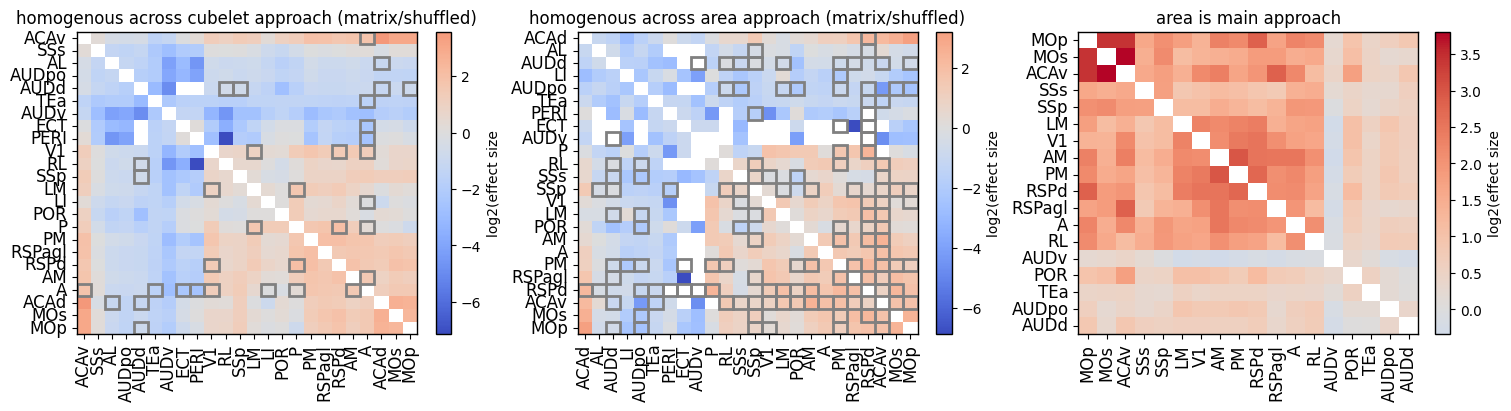

In [13]:
analysis = ['cubelet', 'area', 'main']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
p_value_dict = {}
mean_value_dict = {}
cond_prob_dict_both = {}
cond_prob_dict_both_shuffled = {}
for number, key in enumerate(['cubelet', 'area']):
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    #cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    conditional_prob = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for index, r in conditional_prob.iterrows():
        for column in cols_reordered:
            prob_df = pd.DataFrame()
            prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
            prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            if index ==column:
                conditional_prob.loc[index, column] = np.nan
            else:
                conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))
    cond_prob_dict_both[key]=conditional_prob
    
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    conditional_prob_matrix = pd.DataFrame()
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        try:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = np.nan
        try:    
            conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[1], separated_words[0]] = np.nan
    for column_name in conditional_prob_matrix.columns:
        mean_cond_prob = conditional_prob_matrix[column_name].mean()
        if column_name[0] in cols_reordered and column_name[1] in cols_reordered:
            mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
            val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
            if val_to_comp >= mean_cond_prob:
                #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cond_prob:
                #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[column_name[0], column_name[1]] = p_val
        #p_val_matrix.loc[column_name[1], column_name[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols_reordered)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
   

fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout = True)
analysis_names =['cubelet', 'area', 'main']
for where_to_put, key in enumerate(analysis_names):
    if key in ('cubelet', 'area'):
        p_val_matrix = p_value_dict[key]
        #for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        comparison =(compare_matrices[0])-(compare_matrices[1])
        cols_with_any_inf = np.isinf(comparison).all(axis=0)
        df = comparison.loc[:, ~cols_with_any_inf]
        to_clust = df.copy()
        to_clust = to_clust.replace(np.nan, 0)
        cluster = sb.clustermap(data=to_clust, row_cluster=True,    # Keep clustering on rows
        col_cluster=True, )
        plt.close(cluster.fig)
        row_order = cluster.dendrogram_row.reordered_ind
        row_labels = [cluster.data.index[i] for i in row_order]
        new_df_reordered = df.loc[row_labels, row_labels]
        to_plot = fpf.convert_matrix_names(np.log2(new_df_reordered))
        to_plot.replace([np.inf, -np.inf], np.nan, inplace=True)
        axs[where_to_put].set_title(f'homogenous across {key} approach (matrix/shuffled)')
    
    elif key == 'main':
        all_cols = all_combined[f'area_is_{key}'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        conditional_prob = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for index, r in conditional_prob.iterrows():
            for column in cols_reordered:
                prob_df = pd.DataFrame()
                prob_df["a"] = all_combined[f'area_is_{key}'][column].astype(bool)
                prob_df["b"] = all_combined[f'area_is_{key}'][index].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                if index ==column:
                    conditional_prob.loc[index, column] = np.nan
                else:
                    conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'area_is_{key}'])*(prob_df["b"].sum()/len(all_combined[f'area_is_{key}']))*len(all_combined[f'area_is_{key}']))))
            to_clust = conditional_prob.copy()
            to_clust = to_clust.replace(np.nan, 0)
            cluster = sb.clustermap(data=to_clust, row_cluster=True,    # Keep clustering on rows
            col_cluster=True, metric='canberra')
            plt.close(cluster.fig)
            row_order = cluster.dendrogram_row.reordered_ind
            row_labels = [cluster.data.index[i] for i in row_order]
            new_df_reordered = conditional_prob.loc[row_labels, row_labels]
            to_plot = fpf.convert_matrix_names(np.log2(new_df_reordered))
            #to_plot = np.log2(conditional_prob)
            #to_plot =fpf.convert_matrix_names(to_plot)
            axs[where_to_put].set_title(f'area is main approach')
    sb.heatmap(ax=axs[where_to_put], data =to_plot, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size'})
    for _, spine in axs[where_to_put].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
    
    # axs[where_to_put].set_xlabel('Area B')
    # axs[where_to_put].set_ylabel('Area A')
    axs[where_to_put].tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs[where_to_put].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    if key in ('cubelet', 'area'):
            for ii in compare_matrices[0].columns:
                for j in compare_matrices[0].columns:
                    if p_val_matrix.loc[ii, j] > 0.05:
                        row_idx = p_val_matrix.index.get_loc(ii)  # get the index of the row name
                        col_idx = p_val_matrix.columns.get_loc(j)  
                        axs[where_to_put].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))



In [38]:
all_cols = all_combined[f'homogenous_across_{key}'].columns
#cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
conditional_prob = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
for index, r in conditional_prob.iterrows():
    for column in cols_reordered:
        prob_df = pd.DataFrame()
        prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
        prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
        prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
        if index ==column:
            conditional_prob.loc[index, column] = np.nan
        else:
            conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))
cond_prob_dict_both[key]=conditional_prob

shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
#shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
#num_shuffles=100000 
mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
conditional_prob_matrix = pd.DataFrame()
for column_name in shuffled_2_combinations.columns:
    separated_words = column_name.split(', ')
    try:
        conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
    except ZeroDivisionError:
        conditional_prob_matrix[separated_words[0], separated_words[1]] = np.nan
    try:    
        conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
    except ZeroDivisionError:
        conditional_prob_matrix[separated_words[1], separated_words[0]] = np.nan
for column_name in conditional_prob_matrix.columns:
    mean_cond_prob = conditional_prob_matrix[column_name].mean()
    if column_name[0] in cols_reordered and column_name[1] in cols_reordered:
        mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
        val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
        if val_to_comp >= mean_cond_prob:
            #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
            p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
        elif val_to_comp < mean_cond_prob:
            #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
            p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
        #p_val = scipy.stats.norm.sf(abs(z_value))*2
        p_val_matrix.loc[column_name[0], column_name[1]] = p_val

In [48]:
from sklearn.linear_model import LinearRegression, Lasso
import itertools
proj_folder = "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq"
num_shuffles = 5
warnings.filterwarnings("ignore")
combined_dict_area = {}
combined_dict_cubelet = {}
for num, mouse in enumerate(mice):
    homog_across_cubelet = {}
    homog_across_area = {}
    parameters_path = f"{proj_folder}/{mouse}/Sequencing"
    parameters = fpf.load_parameters(directory=parameters_path)
    sequencing_directory = pathlib.Path(
        "".join(
            [
                parameters["PROCESSED_DIR"],
                "/",
                parameters["PROJECT"],
                "/",
                parameters["MOUSE"],
                "/Sequencing",
            ]
        )
    )
    barcodes_across_sample = pd.read_pickle(
        sequencing_directory / "A1_barcodes_thresholded.pkl"
    )
    lcm_directory = parameters["lcm_directory"]
    barcodes_across_sample = barcodes_across_sample[
        barcodes_across_sample.astype(bool).sum(axis=1) > 0
    ]

    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes_across_sample.columns,
        lcm_directory=lcm_directory,
    )
    areas_matrix = areas_only_grouped.to_numpy()
    total_frac = np.sum(areas_matrix, axis=1)
    frac_matrix = areas_matrix / total_frac[:, np.newaxis]
    weighted_frac_matrix = frac_matrix / areas_matrix.sum(axis=0)
    barcodes = barcodes_across_sample.to_numpy()
    print(f"finished generating area matrix for {mouse}")
    for i in range(num_shuffles):
        barcodes_shuffled = fpf.send_to_shuffle(barcodes=barcodes)
        total_projection_strength = np.sum(barcodes_shuffled, axis=1)
        barcodes_shuffled = (
            barcodes_shuffled / total_projection_strength[:, np.newaxis]
        )
        bc_matrix = np.matmul(barcodes_shuffled, weighted_frac_matrix)
        bc_matrix = pd.DataFrame(
            data=bc_matrix, columns=areas_only_grouped.columns.to_list()
        )
        bc_matrix = bc_matrix.loc[~(bc_matrix == 0).all(axis=1)]
        homog_across_cubelet[i] = bc_matrix.fillna(0)
        normalised_bc_matrix = barcodes_shuffled[
            total_projection_strength > 0, :
        ]  # needed as already removed barcodes with no projections some nan values if shuffled and no projections in some barcodes

        mdl = Lasso(fit_intercept=False, positive=True)
        mdl.fit(areas_matrix, normalised_bc_matrix.T)
        homog_across_area[i] = pd.DataFrame(
            data=mdl.coef_, columns=areas_only_grouped.columns
        )
    combined_dict_cubelet[mouse] = homog_across_cubelet
    combined_dict_area[mouse] = homog_across_area

   
common_columns_cubelet = set(combined_dict_cubelet[mice[0]][0].columns)
common_columns_area = set(combined_dict_area[mice[0]][0].columns)

for mouse in mice[1:]:
    common_columns_cubelet = common_columns_cubelet.intersection(
        combined_dict_cubelet[mouse][0].columns
    )
    common_columns_area = common_columns_area.intersection(
        combined_dict_area[mouse][0].columns
    )

common_columns_cubelet = list(common_columns_cubelet)
common_columns_area = list(common_columns_area)
# common_columns_cubelet = list(set(combined_dict_cubelet['FIAA45.6a'][0].columns).intersection(combined_dict_cubelet['FIAA45.6d'][0].columns))
# common_columns_area = list(set(combined_dict_area['FIAA45.6a'][0].columns).intersection(combined_dict_area['FIAA45.6d'][0].columns))
# all_common_columns = [x for x in common_columns_cubelet if x in common_columns_area] #might want to change this if there is any differences - I don't think there is, but I put just in case
# common_columns_cubelet = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
combinations = []
for col_a, col_b in itertools.combinations(common_columns_cubelet, 2):
    combination_to_add = f"{col_a}, {col_b}"
    combinations.append(combination_to_add)
combinations_area = []
for col_a, col_b in itertools.combinations(common_columns_area, 2):
    combination_to_add_area = f"{col_a}, {col_b}"
    combinations_area.append(combination_to_add_area)
probability_cubelet = pd.DataFrame(columns=combinations)
probability_area = pd.DataFrame(columns=combinations_area)
conditional_prob_cubelet = pd.DataFrame(columns=combinations)
conditional_prob_area = pd.DataFrame(columns=combinations_area)
neuron_numbers_cubelet = pd.DataFrame(columns=common_columns_cubelet)
neuron_numbers_area = pd.DataFrame(columns=common_columns_area)
corr_cubelet = pd.DataFrame(columns=combinations)
corr_area = pd.DataFrame(columns=combinations_area)
corr_cubelet_binary = pd.DataFrame(columns=combinations)
corr_area_binary = pd.DataFrame(columns=combinations_area)
cosine_sim_matrix_cubelet = pd.DataFrame(columns=combinations)
cosine_sim_matrix_area = pd.DataFrame(columns=combinations_area)

finished generating area matrix for FIAA45.6a
finished generating area matrix for FIAA45.6d
finished generating area matrix for FIAA55.4d


In [58]:
conditional_prob_cubelet

,"MOs, ACAd","MOs, VISpm","MOs, Contra","MOs, APN","MOs, AUDp","MOs, LGd","MOs, ECT","MOs, VISal","MOs, AUDpo","MOs, IC",...,"MOp, PIL","VISrl, PIL","SCs, PIL","P, PIL","VISrl, MOp","SCs, MOp","P, MOp","SCs, VISrl","P, VISrl","P, SCs"
0,0.282828,0.087542,0.484848,0.006734,0.575758,0.026936,0.481481,0.558923,0.525253,0.225589,...,0.064024,0.081770,0.107843,0.100000,0.056264,0.083333,0.078947,0.269608,0.115789,0.010526
1,0.288136,0.094915,0.559322,0.010169,0.603390,0.037288,0.511864,0.552542,0.528814,0.264407,...,0.071207,0.066667,0.024390,0.094241,0.071161,0.043902,0.094241,0.282927,0.141361,0.020942
2,0.304054,0.125000,0.496622,0.003378,0.550676,0.023649,0.506757,0.560811,0.550676,0.253378,...,0.077160,0.071111,0.088235,0.120419,0.066667,0.088235,0.078534,0.274510,0.125654,0.010471
3,0.295302,0.083893,0.486577,0.006711,0.570470,0.033557,0.486577,0.540268,0.536913,0.251678,...,0.054878,0.082151,0.092233,0.068421,0.050037,0.067961,0.068421,0.252427,0.110526,0.026316
4,0.292929,0.117845,0.508418,0.010101,0.612795,0.037037,0.481481,0.535354,0.481481,0.252525,...,0.079268,0.076127,0.068293,0.068783,0.061345,0.048780,0.116402,0.297561,0.142857,0.026455


In [49]:
for i in range(num_shuffles):
    if len(mice) > 1:
        shuffled_combined_cubelet = pd.concat(
            [
                combined_dict_cubelet[mouse][i][common_columns_cubelet]
                for mouse in mice
            ],
            ignore_index=True,
        )
        shuffled_combined_area = pd.concat(
            [combined_dict_area[mouse][i][common_columns_area] for mouse in mice],
            ignore_index=True,
        )

    else:
        shuffled_combined_cubelet = combined_dict_cubelet[mouse][i]
        shuffled_combined_area = combined_dict_area[mouse][i]
    # for i in range(num_shuffles):
    #     shuffled_combined_cubelet = pd.concat([combined_dict_cubelet['FIAA45.6a'][i][cols], combined_dict_cubelet['FIAA45.6d'][i][cols]], ignore_index=True)
    #     shuffled_combined_area = pd.concat([combined_dict_area['FIAA45.6a'][i][cols], combined_dict_area['FIAA45.6d'][i][cols]], ignore_index=True)
    for which, matrix in enumerate(
        [shuffled_combined_cubelet, shuffled_combined_area]
    ):
        dict_to_add = {}
        num_dict = {}
        pearson_corr_dict = {}
        binary_corr_dict = {}
        cosine_dict = {}
        cond_prob_dict = {}
        for column in matrix.columns:
            num_dict[column] = matrix[column].astype(bool).sum()
        for col_a, col_b in itertools.combinations(matrix.columns, 2):
            prob_df = pd.DataFrame()
            prob_df["a"] = matrix[col_a].astype(bool)
            prob_df["b"] = matrix[col_b].astype(bool)
            prob_df["matching"] = prob_df.apply(
                lambda x: 1 if x["a"] and x["b"] else 0, axis=1
            )
            dict_to_add[f"{col_a}, {col_b}"] = prob_df["matching"].sum()
            pearson_corr_dict[f"{col_a}, {col_b}"] = matrix[col_a].corr(
                matrix[col_b], method="spearman"
            )
            binary_corr_dict[f"{col_a}, {col_b}"] = (
                matrix[col_a]
                .astype(bool)
                .corr(matrix[col_b].astype(bool), method="spearman")
            )
            cond_prob_dict[f"{col_a}, {col_b}"] = (
                matrix[matrix[col_a] > 0].astype(bool).astype(int)[col_b].mean()
            )
            cond_prob_dict[f"{col_b}, {col_a}"] = (
                matrix[matrix[col_b] > 0].astype(bool).astype(int)[col_a].mean()
            )
            neurons_1_av = matrix[matrix[col_a] > 0].mean(axis=0)
            neurons_2_av = matrix[matrix[col_b] > 0].mean(axis=0)
            if (
                neurons_2_av.isna().all() or neurons_1_av.isna().all()
            ):  # for some in shuffle, no longer any projections to certian areas using the homog across area approach
                cosine_dict[f"{col_a}, {col_b}"] = np.nan
            else:
                neurons_1_av_arr = np.array(neurons_1_av).reshape(1, -1)
                neurons_2_av_arr = np.array(neurons_2_av).reshape(1, -1)
                cosine_sim = cosine_similarity(neurons_1_av_arr, neurons_2_av_arr)
                cosine_dict[f"{col_a}, {col_b}"] = cosine_sim[0][0]
        if which == 0:
            probability_cubelet = pd.concat(
                [probability_cubelet, pd.DataFrame(dict_to_add, index=[i])]
            )
            neuron_numbers_cubelet = pd.concat(
                [neuron_numbers_cubelet, pd.DataFrame(num_dict, index=[i])]
            )
            corr_cubelet = pd.concat(
                [corr_cubelet, pd.DataFrame(pearson_corr_dict, index=[i])]
            )
            corr_cubelet_binary = pd.concat(
                [corr_cubelet_binary, pd.DataFrame(binary_corr_dict, index=[i])]
            )
            cosine_sim_matrix_cubelet = pd.concat(
                [cosine_sim_matrix_cubelet, pd.DataFrame(cosine_dict, index=[i])]
            )
            conditional_prob_cubelet = pd.concat(
                [conditional_prob_cubelet, pd.DataFrame(cond_prob_dict, index=[i])]
            )
        if which == 1:
            probability_area = pd.concat(
                [probability_area, pd.DataFrame(dict_to_add, index=[i])]
            )
            neuron_numbers_area = pd.concat(
                [neuron_numbers_area, pd.DataFrame(num_dict, index=[i])]
            )
            corr_area = pd.concat(
                [corr_area, pd.DataFrame(pearson_corr_dict, index=[i])]
            )
            corr_area_binary = pd.concat(
                [corr_area_binary, pd.DataFrame(binary_corr_dict, index=[i])]
            )
            cosine_sim_matrix_area = pd.concat(
                [cosine_sim_matrix_area, pd.DataFrame(cosine_dict, index=[i])]
            )
            conditional_prob_area = pd.concat(
                [conditional_prob_area, pd.DataFrame(cond_prob_dict, index=[i])]
            )

In [59]:
blbl = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_area_2_comb__collated.pkl').reset_index(drop=True)

In [34]:
key = 'area'
shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
for column_name in shuffled_2_combinations.columns:
    if 'MOp' in column_name and 'ACAv' in column_name:
        blbl= column_name
        

In [60]:
look = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_cubelet_2_comb__collated.pkl').reset_index(drop=True)

In [62]:
probability_cubelet

,"MOs, ACAd","MOs, VISpm","MOs, Contra","MOs, APN","MOs, AUDp","MOs, LGd","MOs, ECT","MOs, VISal","MOs, AUDpo","MOs, IC",...,"PIL, MOp","PIL, VISrl","PIL, SCs","PIL, P","MOp, VISrl","MOp, SCs","MOp, P","VISrl, SCs","VISrl, P","SCs, P"
0,84,26,144,2,171,8,143,166,156,67,...,21,109,22,19,75,17,15,55,22,2
1,85,28,165,3,178,11,151,163,156,78,...,23,89,5,18,95,9,18,58,27,4
2,90,37,147,1,163,7,150,166,163,75,...,25,96,18,23,90,18,15,56,24,2
3,88,25,145,2,170,10,145,161,160,75,...,18,110,19,13,67,14,13,52,21,5
4,87,35,151,3,182,11,143,159,143,75,...,26,103,14,13,83,10,22,61,27,5


In [61]:
look

,"AUDpo, VPL","AUDpo, SCm","AUDpo, SSs","AUDpo, VISpor","AUDpo, VISli","AUDpo, MGd","AUDpo, VISl","AUDpo, Contra","AUDpo, OB","AUDpo, SGN",...,"MGm, VISl","MGm, VISrl","VISa, LP","AUDv, OB","SCs, HPF","SCs, OB","RSPagl, OB","RT, OB","MGm, SSp","TEa, LP"
0,2,488,1293,810,538,92,571,1464,0,103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,479,1273,844,504,100,553,1474,4,111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,467,1267,851,521,86,549,1487,0,93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,440,1280,813,527,89,562,1470,0,90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,476,1273,855,502,79,545,1480,1,87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,455,NaN,NaN,NaN,95,540,NaN,NaN,NaN,...,84,102,35,NaN,NaN,NaN,NaN,0,113,NaN
99996,NaN,479,NaN,NaN,NaN,86,570,NaN,NaN,NaN,...,68,127,37,NaN,NaN,NaN,NaN,0,136,NaN
99997,NaN,472,NaN,NaN,NaN,92,539,NaN,NaN,NaN,...,101,123,39,NaN,NaN,NaN,NaN,0,128,NaN
99998,NaN,477,NaN,NaN,NaN,87,570,NaN,NaN,NaN,...,73,117,29,NaN,NaN,NaN,NaN,0,130,NaN


In [27]:
separated_words = blbl.split(', ')
key = 'area'
try:
    x = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
except ZeroDivisionError:
    y= np.nan
try:    
    z = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
except ZeroDivisionError:
    za= np.nan

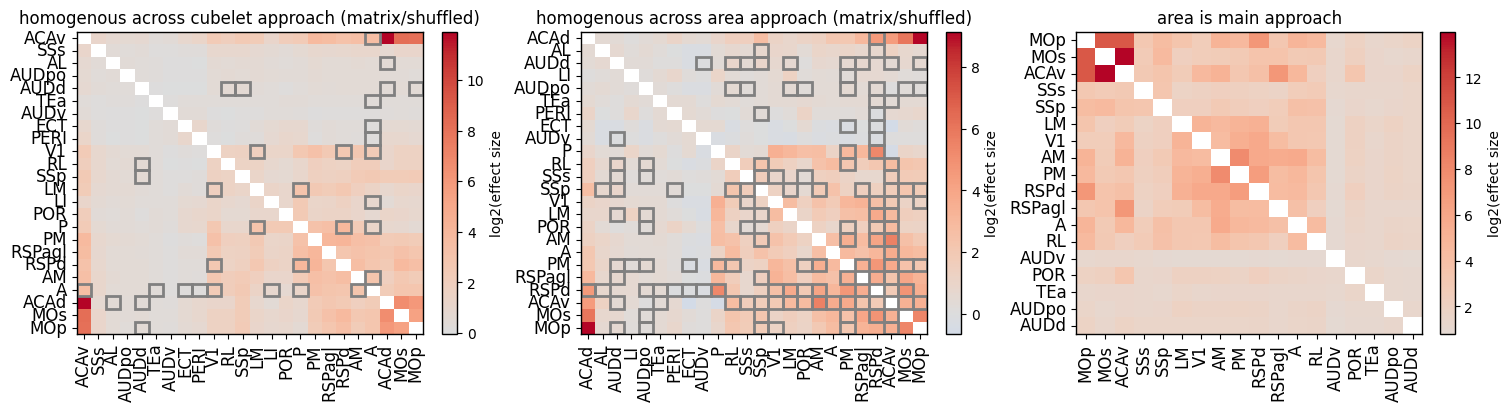

In [14]:

fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout = True)
analysis_names =['cubelet', 'area', 'main']
for where_to_put, key in enumerate(analysis_names):
    if key in ('cubelet', 'area'):
        p_val_matrix = p_value_dict[key]
        #for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        comparison =(compare_matrices[0])-(compare_matrices[1])
        cols_with_any_inf = np.isinf(comparison).all(axis=0)
        df = comparison.loc[:, ~cols_with_any_inf]
        to_clust = df.copy()
        to_clust = to_clust.replace(np.nan, 0)
        cluster = sb.clustermap(data=to_clust, row_cluster=True,    # Keep clustering on rows
        col_cluster=True, )
        plt.close(cluster.fig)
        row_order = cluster.dendrogram_row.reordered_ind
        row_labels = [cluster.data.index[i] for i in row_order]
        new_df_reordered = df.loc[row_labels, row_labels]
        to_plot = fpf.convert_matrix_names(new_df_reordered)
        to_plot.replace([np.inf, -np.inf], np.nan, inplace=True)
        axs[where_to_put].set_title(f'homogenous across {key} approach (matrix/shuffled)')
    
    elif key == 'main':
        all_cols = all_combined[f'area_is_{key}'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        conditional_prob = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for index, r in conditional_prob.iterrows():
            for column in cols_reordered:
                prob_df = pd.DataFrame()
                prob_df["a"] = all_combined[f'area_is_{key}'][column].astype(bool)
                prob_df["b"] = all_combined[f'area_is_{key}'][index].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                if index ==column:
                    conditional_prob.loc[index, column] = np.nan
                else:
                    conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'area_is_{key}'])*(prob_df["b"].sum()/len(all_combined[f'area_is_{key}']))*len(all_combined[f'area_is_{key}']))))
            to_clust = conditional_prob.copy()
            to_clust = to_clust.replace(np.nan, 0)
            cluster = sb.clustermap(data=to_clust, row_cluster=True,    # Keep clustering on rows
            col_cluster=True, metric='canberra')
            plt.close(cluster.fig)
            row_order = cluster.dendrogram_row.reordered_ind
            row_labels = [cluster.data.index[i] for i in row_order]
            new_df_reordered = conditional_prob.loc[row_labels, row_labels]
            to_plot = fpf.convert_matrix_names(new_df_reordered)
            #to_plot = np.log2(conditional_prob)
            #to_plot =fpf.convert_matrix_names(to_plot)
            axs[where_to_put].set_title(f'area is main approach')
    sb.heatmap(ax=axs[where_to_put], data =to_plot, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size'})
    for _, spine in axs[where_to_put].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
    
    # axs[where_to_put].set_xlabel('Area B')
    # axs[where_to_put].set_ylabel('Area A')
    axs[where_to_put].tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs[where_to_put].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    if key in ('cubelet', 'area'):
        for ii in compare_matrices[0].columns:
            for j in compare_matrices[0].columns:
                if p_val_matrix.loc[ii, j] > 0.05:
                    row_idx = p_val_matrix.index.get_loc(ii)  # get the index of the row name
                    col_idx = p_val_matrix.columns.get_loc(j)  
                    axs[where_to_put].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))



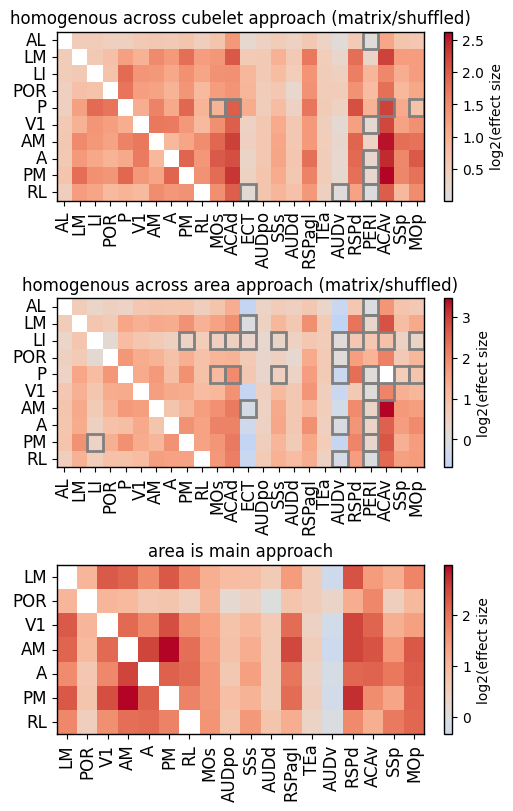

In [5]:
analysis = ['cubelet', 'area', 'main']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
p_value_dict = {}
mean_value_dict = {}
cond_prob_dict_both = {}
cond_prob_dict_both_shuffled = {}
for number, key in enumerate(['cubelet', 'area']):
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    #cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    for index, r in conditional_prob.iterrows():
        for column in cols_reordered:
            prob_df = pd.DataFrame()
            prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
            prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            if index ==column:
                conditional_prob.loc[index, column] = np.nan
            else:
                conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))
    cond_prob_dict_both[key]=conditional_prob
    
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    conditional_prob_matrix = pd.DataFrame()
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        try:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = np.nan
        try:    
            conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[1], separated_words[0]] = np.nan
    for column_name in conditional_prob_matrix.columns:
        mean_cond_prob = conditional_prob_matrix[column_name].mean()
        if column_name[0] in cols and column_name[1] in cols_reordered:
            mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
            val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
            if val_to_comp >= mean_cond_prob:
                #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cond_prob:
                #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[column_name[0], column_name[1]] = p_val
        #p_val_matrix.loc[column_name[1], column_name[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
   

fig, axs = plt.subplots(3, 1, figsize=(5, 8), constrained_layout = True)
analysis_names =['cubelet', 'area', 'main']
for where_to_put, key in enumerate(analysis_names):
    if key in ('cubelet', 'area'):
        p_val_matrix = p_value_dict[key]
        #for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        comparison = compare_matrices[0]/compare_matrices[1]
        cols_with_any_inf = np.isinf(comparison).any(axis=0)
        df = comparison.loc[:, ~cols_with_any_inf]
        to_plot = fpf.convert_matrix_names(np.log2(df))
        to_plot.replace([np.inf, -np.inf], np.nan, inplace=True)
        axs[where_to_put].set_title(f'homogenous across {key} approach (matrix/shuffled)')
    elif key == 'main':
        all_cols = all_combined[f'area_is_{key}'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
        for index, r in conditional_prob.iterrows():
            for column in cols_reordered:
                prob_df = pd.DataFrame()
                prob_df["a"] = all_combined[f'area_is_{key}'][column].astype(bool)
                prob_df["b"] = all_combined[f'area_is_{key}'][index].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                if index ==column:
                    conditional_prob.loc[index, column] = np.nan
                else:
                    conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'area_is_{key}'])*(prob_df["b"].sum()/len(all_combined[f'area_is_{key}']))*len(all_combined[f'area_is_{key}']))))
            to_plot = np.log2(conditional_prob)
            to_plot =fpf.convert_matrix_names(to_plot)
            axs[where_to_put].set_title(f'area is main approach')
    sb.heatmap(ax=axs[where_to_put], data =to_plot, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size'})
    for _, spine in axs[where_to_put].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
    
    # axs[where_to_put].set_xlabel('Area B')
    # axs[where_to_put].set_ylabel('Area A')
    axs[where_to_put].tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs[where_to_put].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    if key in ('cubelet', 'area'):
        for ii in range(len(cols)):
            for j in range(len( compare_matrices[0].columns)):
                if p_val_matrix.iloc[ii, j] > 0.05:
                    axs[where_to_put].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))


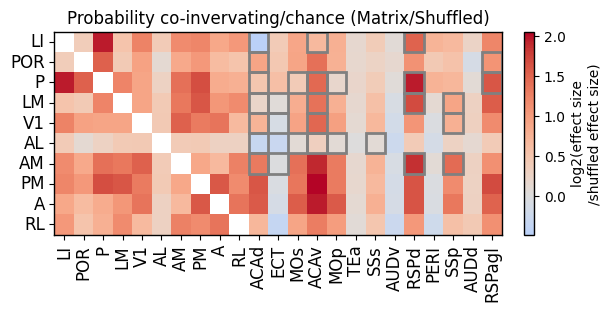

In [79]:
#just plot homog across cubelet
fig, axs = plt.subplots(1, figsize=(6, 3), constrained_layout = True)
analysis_names =['cubelet']
for where_to_put, key in enumerate(analysis_names):
    p_val_matrix = p_value_dict[key]
    compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
    comparison = compare_matrices[0]/compare_matrices[1]
    cols_with_any_inf = np.isinf(comparison).any(axis=0)
    df = comparison.loc[:, ~cols_with_any_inf]
    to_plot = fpf.convert_matrix_names(np.log2(df))
    to_plot.replace([np.inf, -np.inf], np.nan, inplace=True)
    sb.heatmap(ax=axs, data =to_plot, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size\n/shuffled effect size)'})
    for _, spine in axs.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs.collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
    axs.set_title('Probability co-invervating/chance (Matrix/Shuffled)')
    # axs.set_xlabel('Area B')
    # axs.set_ylabel('Area A')
    axs.tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs.tick_params(axis='y', which='major', labelsize=12, rotation=0)
    for ii in range(len(cols)):
        for j in range(len(compare_matrices[0].columns)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs.add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))

Correlations

In [6]:
#cols = [ 'VISpl','VISpor', 'VISli', 'VISl', 'VISp', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISa']
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
for number, key in enumerate(analysis):
    shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    for column_name in shuffled_corr.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_corr[column_name].mean()
        if separated_words[0] in cols and separated_words[1] in cols_reordered:
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
            if separated_words[1] in cols:
                mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
            val_to_comp = all_combined[f'homogenous_across_{key}'].corr(method='spearman').loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_corr:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value > val_to_comp)/len(shuffled_corr))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_corr:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value < val_to_comp)/len(shuffled_corr))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            if separated_words[1] in cols:
                p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix

KeyError: 'area_is_main'

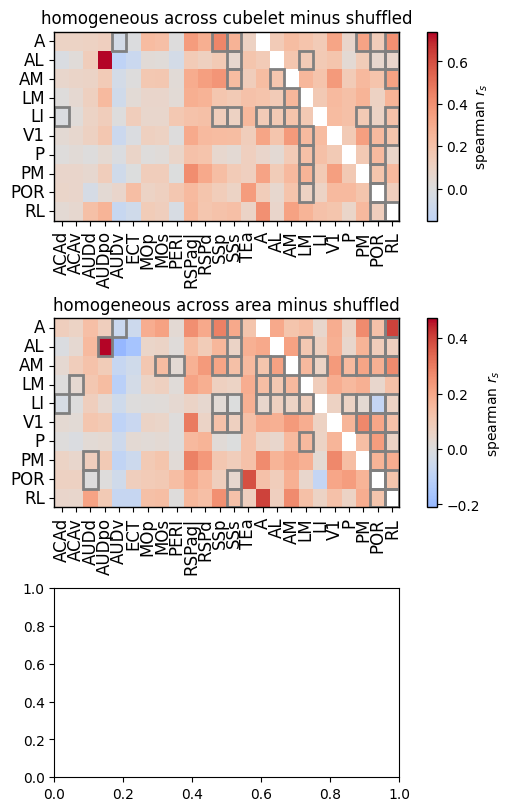

In [7]:

fig, axs = plt.subplots(3, 1, figsize=(5, 8), constrained_layout = True)

analysis = ['cubelet', 'area', 'main']


for number, key in enumerate(analysis):
    if key in ('cubelet', 'area'):
        cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
        all_cols = all_combined[f'homogenous_across_{key}'].columns
        #cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        matrix_correlation = all_combined[f'homogenous_across_{key}'][cols_reordered].corr(method='spearman').loc[cols]
        mean_shuffled = mean_value_dict[key]
        p_val_matrix = p_value_dict[key]
        np.fill_diagonal(matrix_correlation.values, np.nan)
        subtracted = matrix_correlation - mean_shuffled
        sb.heatmap(ax=axs[number], data=fpf.convert_matrix_names(subtracted), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
        axs[number].set_title(f'homogeneous across {key} minus shuffled')
        for ii in range(len(cols)):
            for j in range(len(cols_reordered)):
                if p_val_matrix.iloc[ii, j] > 0.05:
                    axs[number].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    if key == 'main':
        all_cols = all_combined[f'area_is_{key}'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        matrix_correlation = all_combined[f'area_is_{key}'][cols_reordered].corr(method='spearman').loc[cols]
        np.fill_diagonal(matrix_correlation.values, np.nan)
        sb.heatmap(ax=axs[number], data=fpf.convert_matrix_names(matrix_correlation), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
        axs[number].set_title(f'area is {key} approach')
    
    for _, spine in axs[number].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[number].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
    axs[number].tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    
  
#plt.suptitle('Correlation matrices for mice combined', size=20)

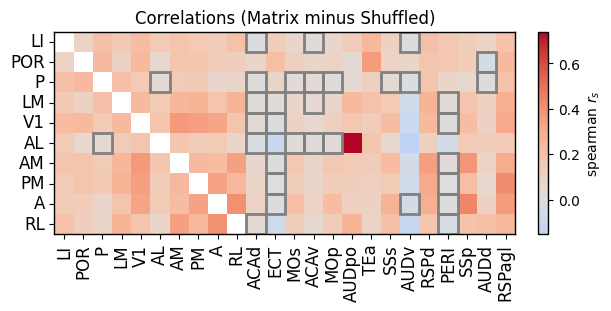

In [ ]:
fig, axs = plt.subplots(1, figsize=(6, 3), constrained_layout = True)
analysis_names =['cubelet']
for number, key in enumerate(analysis_names):
    cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    #cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    matrix_correlation = all_combined[f'homogenous_across_{key}'][cols_reordered].corr(method='spearman').loc[cols]
    mean_shuffled = mean_value_dict[key]
    p_val_matrix = p_value_dict[key]
    np.fill_diagonal(matrix_correlation.values, np.nan)
    subtracted = matrix_correlation - mean_shuffled
    sb.heatmap(ax=axs, data=fpf.convert_matrix_names(subtracted), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    #axs.set_title(f'homogeneous across {key} minus shuffled')
    for _, spine in axs.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs.collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    for ii in range(len(cols)):
        for j in range(len(cols_reordered)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs.add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    axs.tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs.tick_params(axis='y', which='major', labelsize=12, rotation=0)
    axs.set_title('Correlations (Matrix minus Shuffled)')

Conditional probability

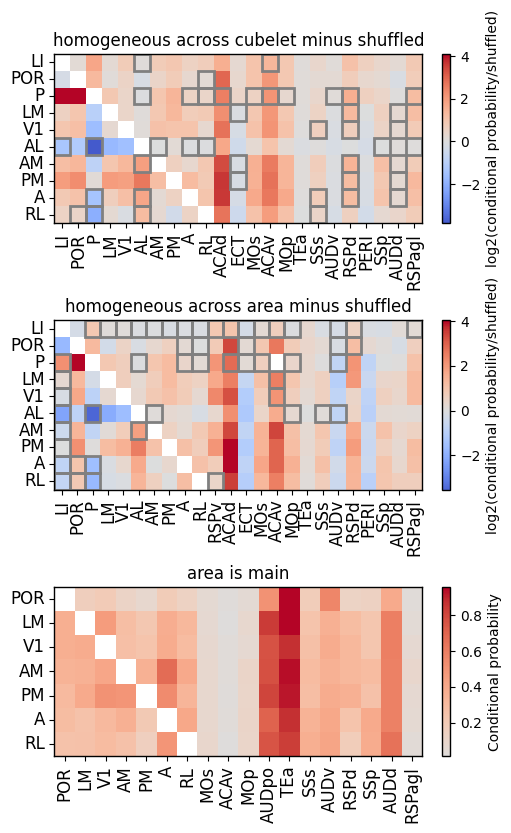

In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(5, 8), constrained_layout = True)

analysis = ['cubelet', 'area', 'main']
cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
cond_prob_dict = {}

for number, key in enumerate(analysis):
    if key in ('cubelet', 'area'):
        all_cols = all_combined[f'homogenous_across_{key}'].columns
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
        matrix = all_combined[f'homogenous_across_{key}'][cols_reordered]
        shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_conditional_prob__collated.pkl')
        for col in cols:
            for area in cols_reordered:
                if col == area:
                    conditional_prob.loc[col, area] = np.nan
                else:
                    conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
        cond_prob_dict[key] = conditional_prob
        mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
        p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
        for column_name in shuffled_cond_prob.columns:
            separated_words = column_name.split(', ')
            mean_corr = shuffled_cond_prob[column_name].mean()
            if separated_words[0] in cols and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
                if separated_words[1] in cols:
                    mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
                val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
                if val_to_comp >= mean_corr:
                    #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                    #p_val = scipy.stats.norm.sf(abs(z_value))*2
                elif val_to_comp < mean_corr:
                    #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                if separated_words[1] in cols:
                    p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        np.fill_diagonal(mean_val_matrix.values, np.nan)
        np.fill_diagonal(p_val_matrix.values, np.nan)
        number_tests = len(cols)* (len(cols_reordered)-1)
        p_val_matrix = p_val_matrix*number_tests #bonferroni correction
        # p_value_dict[key] = p_val_matrix
        # mean_value_dict[key] = mean_val_matrix
        matrix_div_shuff = np.log2(conditional_prob/ mean_val_matrix)
        matrix_div_shuff.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Drop columns that contain all NaN values
        matrix_div_shuff.dropna(axis=1, how='all', inplace=True)
        #mean_shuffled = mean_value_dict[key]
        #p_val_matrix = p_value_dict[key]
        #np.fill_diagonal(matrix_correlation.values, np.nan)
        #subtracted = matrix_correlation - mean_shuffled
        sb.heatmap(ax=axs[number], data=fpf.convert_matrix_names(matrix_div_shuff), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(conditional probability/shuffled)'}) #norm=colors.SymLogNorm(linthresh=0.00001))
        axs[number].set_title(f'homogeneous across {key} minus shuffled')
        for ii in range(len(cols)):
            for j in range(len(matrix_div_shuff.columns)):
                if p_val_matrix.iloc[ii, j] > 0.05:
                    axs[number].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    if key == 'main':
        all_cols = all_combined['area_is_main'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(all_cols))), columns= cols_reordered, index=cols)
        matrix = all_combined[f'area_is_{key}'][cols_reordered]
        for col in cols:
            for area in cols_reordered:
                if col == area:
                    conditional_prob.loc[col, area] = np.nan
                else:
                    conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
        sb.heatmap(ax=axs[number], data=fpf.convert_matrix_names(conditional_prob), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'Conditional probability'})
        axs[number].set_title(f'area is {key}')
    for _, spine in axs[number].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[number].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    axs[number].tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    
  
#plt.suptitle('Correlation matrices for mice combined', size=20)

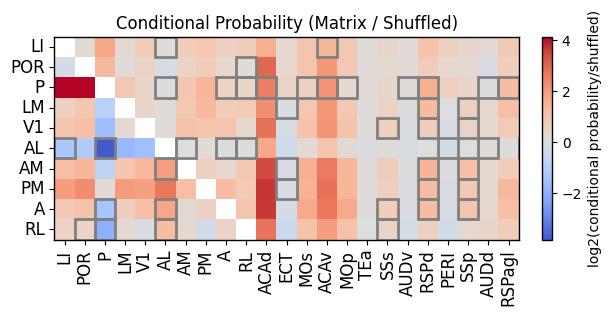

In [ ]:
fig, axs = plt.subplots(1, figsize=(6, 3), constrained_layout = True)
analysis_names =['cubelet']
for number, key in enumerate(analysis_names):
    cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    #cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    

    conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    matrix = all_combined[f'homogenous_across_{key}'][cols_reordered]
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_conditional_prob__collated.pkl')
    for col in cols:
        for area in cols_reordered:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    cond_prob_dict[key] = conditional_prob
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols)
    for column_name in shuffled_cond_prob.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_cond_prob[column_name].mean()
        if separated_words[0] in cols and separated_words[1] in cols_reordered:
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
            if separated_words[1] in cols:
                mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
            val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_corr:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_corr:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            if separated_words[1] in cols:
                p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    matrix_div_shuff = np.log2(conditional_prob/ mean_val_matrix)
    matrix_div_shuff.replace([np.inf, -np.inf], np.nan, inplace=True)
    matrix_div_shuff.dropna(axis=1, how='all', inplace=True)
    sb.heatmap(ax=axs, data=fpf.convert_matrix_names(matrix_div_shuff), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(conditional probability/shuffled)'})  
    

    for _, spine in axs.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs.collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    for ii in range(len(cols)):
        for j in range(len(cols_reordered)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs.add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    axs.tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs.tick_params(axis='y', which='major', labelsize=12, rotation=0)
    axs.set_title('Conditional Probability (Matrix / Shuffled)')

Cosine similarity between mean projections

In [ ]:
#cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
#columns_to_restrict = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl', 'RSPv', 'RSPd', 'IC', 'SCs', 'STR', 'RSPagl', 'SCm', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'MGv', 'LP', 'LGd', 'LGv', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']
cosine_dict = {}
for analysis in ['cubelet', 'area']:
    all_cols = all_combined[f'homogenous_across_{analysis}'].columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [col for col in cols_reordered if col != 'AUDp']
    cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    matrix_to_look = all_combined[f'homogenous_across_{analysis}'][cols_reordered]
    for col in cols:
        for col_2 in cols:
            neurons_1 = matrix_to_look[matrix_to_look[col] >0].mean(axis=0)
            neurons_2 = matrix_to_look[matrix_to_look[col_2] >0].mean(axis=0)
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            cosine_sim = cosine_similarity(bl, bl_2)
            cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
            cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
    cosine_dict[analysis] = cosine_sim_matrix
    
    


In [ ]:
analysis = ['cubelet', 'area']
columns_looked = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl', 'RSPv', 'RSPd', 'IC', 'SCs', 'STR', 'RSPagl', 'SCm', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'MGv', 'LP', 'LGd', 'LGv', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']
p_value_dict = {}
shuf_mean_value_dict = {}
for number, key in enumerate(analysis):
    #shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{analysis}_collated.pkl')
    shuffled_cosine = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_cosine_sim__collated.pkl')
    #shuffled_cosine = shuffled_cosine.drop(columns=columns_looked)
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for column_name in shuffled_cosine.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols and separated_words[1] in cols:
            mean_cosine = shuffled_cosine[column_name].mean()
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_cosine
            mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_cosine
            val_to_comp = cosine_dict[key].loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_cosine:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_cosine[column_name] if value > val_to_comp)/len(shuffled_cosine))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cosine:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_cosine[column_name] if value < val_to_comp)/len(shuffled_cosine))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
    number_tests = len(cols)* (len(cols)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    shuf_mean_value_dict[key] = mean_val_matrix

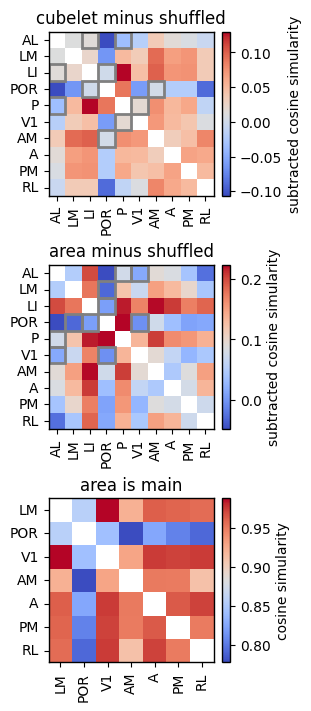

In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(3, 7), constrained_layout = True)
analysis_names =['cubelet', 'area', 'main']
for where_to_put, key in enumerate(analysis_names):
    if key in ('cubelet', 'area'):
        matrix = cosine_dict[key]
        shuff = shuf_mean_value_dict[key]
        p_val_matrix = p_value_dict[key]
        subtracted = matrix - shuff
        np.fill_diagonal(subtracted.values, np.nan)
        sb.heatmap(ax=axs[where_to_put], data=fpf.convert_matrix_names(subtracted), cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'label': 'subtracted cosine simularity'}) #norm=colors.SymLogNorm(linthresh=0.00001))
        axs[where_to_put].set_title(f'{key} minus shuffled')
        for ii in range(len(cols)):
            for j in range(len(cols)):
                if p_val_matrix.iloc[ii, j] > 0.05:
                    axs[where_to_put].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    elif key == 'main':
        all_cols = all_combined['area_is_main'].columns
        cols = [col for col in cols if col in all_cols]
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [col for col in cols_reordered if col != 'AUDp']
        cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
        matrix_to_look = all_combined[f'area_is_{key}'][cols_reordered]
        for col in cols:
            for col_2 in cols:
                neurons_1 = matrix_to_look[matrix_to_look[col] >0].mean(axis=0)
                neurons_2 = matrix_to_look[matrix_to_look[col_2] >0].mean(axis=0)
                bl = np.array(neurons_1).reshape(1, -1)
                bl_2 = np.array(neurons_2).reshape(1, -1)
                cosine_sim = cosine_similarity(bl, bl_2)
                cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
                cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
        np.fill_diagonal(cosine_sim_matrix.values, np.nan)
        sb.heatmap(ax=axs[where_to_put], data=fpf.convert_matrix_names(cosine_sim_matrix), cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine simularity'}) 
        axs[where_to_put].set_title('area is main')
    axs[where_to_put].set_xticklabels(axs[where_to_put].get_xticklabels(), rotation=90)
    axs[where_to_put].set_yticklabels(axs[where_to_put].get_xticklabels(), rotation=0) 
    for _, spine in axs[where_to_put].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
#plt.suptitle('Cosine simularity matrices for mice combined', size=20)

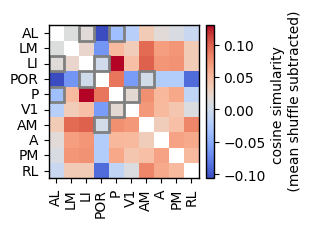

In [ ]:

fig, axs = plt.subplots(1, figsize=(3, 2), constrained_layout = True)
analysis_names =['cubelet']
for where_to_put, key in enumerate(analysis_names):
    if key in ('cubelet', 'area'):
        matrix = cosine_dict[key]
        shuff = shuf_mean_value_dict[key]
        p_val_matrix = p_value_dict[key]
        subtracted = matrix - shuff
        np.fill_diagonal(subtracted.values, np.nan)
        sb.heatmap(ax=axs, data=fpf.convert_matrix_names(subtracted), cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine simularity \n (mean shuffle subtracted)'}) #norm=colors.SymLogNorm(linthresh=0.00001))
        #axs.set_title(f'{key} minus shuffled')
        for ii in range(len(cols)):
            for j in range(len(cols)):
                if p_val_matrix.iloc[ii, j] > 0.05:
                    axs.add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    
 
    axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
    axs.set_yticklabels(axs.get_xticklabels(), rotation=0) 
    for _, spine in axs.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs.collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    
#plt.suptitle('Cosine simularity matrices for mice combined', size=20)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'V1'),
  Text(0, 1.5, 'POR'),
  Text(0, 2.5, 'LI'),
  Text(0, 3.5, 'AL'),
  Text(0, 4.5, 'LM'),
  Text(0, 5.5, 'P'),
  Text(0, 6.5, 'PM'),
  Text(0, 7.5, 'RL'),
  Text(0, 8.5, 'AM'),
  Text(0, 9.5, 'A')])

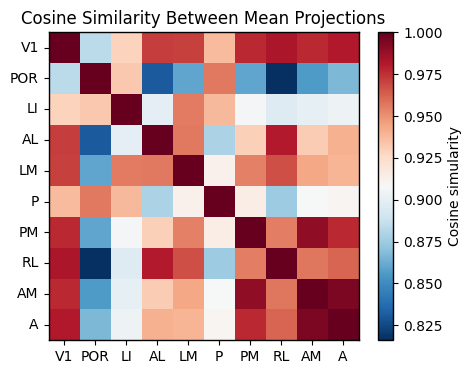

In [47]:
plt.figure(figsize=(5,4))
cosine_sim_matrix_renamed = fpf.convert_matrix_names(cosine_sim_matrix)

ax= sb.heatmap(cosine_sim_matrix_renamed, cmap='RdBu_r', cbar_kws={'label': 'Cosine simularity'})
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
plt.title('Cosine Similarity Between Mean Projections')
plt.yticks(rotation=0) 

In [ ]:
bl = 'lkj'

In [ ]:
fig, axs = plt.subplots(1, figsize=(6, 3), constrained_layout = True)
analysis_names =['cubelet']
for number, key in enumerate(analysis):
    all_cols = all_combined[f'homogenous_across_{key}'].columns
    #cols_reordered = [item for item in all_cols if item in cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    matrix_correlation = all_combined[f'homogenous_across_{key}'][cols_reordered].corr(method='spearman').loc[cols]
    mean_shuffled = mean_value_dict[key]
    p_val_matrix = p_value_dict[key]
    np.fill_diagonal(matrix_correlation.values, np.nan)
    subtracted = matrix_correlation - mean_shuffled
    heatmap =sb.heatmap(ax=axs, data=fpf.convert_matrix_names(subtracted), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar=False)#, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    #axs.set_title(f'homogeneous across {key} minus shuffled')
    for _, spine in axs.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = fig.colorbar(
        heatmap.get_children()[0],
        ax=axs,
        orientation='vertical',
        fraction=0.046,  # Adjusts the size of the colorbar
        pad=0.04         # Adjusts the space between the heatmap and colorbar
    )
    cbar.set_label('Spearman $r_{s}$')
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    for ii in range(len(cols)):
        for j in range(len(cols)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs.add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
    axs.tick_params(axis='x', which='major', labelsize=12, rotation=90)
    axs.tick_params(axis='y', which='major', labelsize=12, rotation=0)
    axs.set_title('Correlations (Matrix minus Shuffled)')

In [ ]:
# #areas where similar amounts were sampled
# area_df_dict = {}
# for mouse in mice:
#     parameters_path = (
#         f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
#     parameters = ps.load_parameters(directory=parameters_path)
#     barcodes_across_sample = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
#     lcm_directory = parameters['lcm_directory']
#     sample_vol_and_regions = pd.read_pickle(''.join([lcm_directory, '/sample_vol_and_regions.pkl']))
#     sample_vol_and_regions = pd.read_pickle(''.join([lcm_directory, '/sample_vol_and_regions.pkl']))
#     sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
#     sample_vol_and_regions['breakdown'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
#     all_areas_unique_acronymn = np.unique(sample_vol_and_regions['regions'].explode().to_list())
#     for column in barcodes_across_sample.columns:
#         #all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
#         index = sample_vol_and_regions[sample_vol_and_regions['ROI Number']==column].index
#         reg = pd.DataFrame()
#         reg['regions'] = [i for i in sample_vol_and_regions.loc[index, 'regions']][0]
#         reg['fraction'] = [i for i in sample_vol_and_regions.loc[index, 'breakdown']][0]
#         reg['counts'] = reg['fraction']*sample_vol_and_regions.loc[index, 'vol_in_atlas'].item()
        
   
#     all_area_df = pd.DataFrame(
#         index=barcodes_across_sample.columns, columns=all_areas_unique_acronymn
#     )
#     for column in barcodes_across_sample.columns:
#         # all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
#         index = sample_vol_and_regions[
#             sample_vol_and_regions["ROI Number"] == column
#         ].index
#         reg = pd.DataFrame()
#         reg["regions"] = [i for i in sample_vol_and_regions.loc[index, "regions"]][0]
#         reg["fraction"] = [i for i in sample_vol_and_regions.loc[index, "breakdown"]][0]
#         reg["vol_area"] = (
#             reg["fraction"] * sample_vol_and_regions.loc[index, "Volume (um^3)"].item()
#         )

#         for _, row in reg.iterrows():
#             all_area_df.loc[column, row["regions"]] = row["vol_area"]
#     group_areas = {"Contra": all_area_df.filter(like="Contra").columns}
#     areas_grouped = all_area_df.copy()
#     for group, columns in group_areas.items():
#         areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
#         columns = [value for value in columns if value in all_area_df.columns]
#         areas_grouped = areas_grouped.drop(columns, axis=1)
#     nontarget_list = ["fiber tracts", "root"]
#     nontarget_list = [value for value in nontarget_list if value in all_area_df.columns]
#     areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)
#     areas_only_grouped =areas_only_grouped.fillna(0)
#     area_df_dict[mouse] = areas_only_grouped

In [ ]:

#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']

cols = [ 'VISpl','VISpor', 'VISli', 'VISl', 'VISp', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISa']
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
for number, key in enumerate(analysis):
    #shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{analysis}_collated.pkl')
    shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    #shuffled_2_combinations = pd.read_pickle('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{analysis}_2_comb_collated.pkl')
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for column_name in shuffled_corr.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_corr[column_name].mean()
        if separated_words[0] in all_combined[f'homogenous_across_{key}'].columns and separated_words[1] in all_combined[f'homogenous_across_{key}'].columns:
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
            mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
            val_to_comp = all_combined[f'homogenous_across_{key}'].corr(method='spearman').loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_corr:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value > val_to_comp)/len(shuffled_corr))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_corr:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value < val_to_comp)/len(shuffled_corr))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix

In [ ]:
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)

In [ ]:
def convert_matrix_names(matrix):
    convert_dict = {'VISp': 'V1','VISpor': 'POR', 'VISli': 'LI', 'VISal': 'AL', 'VISl': 'LM', 'VISpl': 'P', 'VISpm': 'PM', 'VISrl': 'RL', 'VISam': 'AM', 'VISa': 'A'}
    matrix.rename(columns=convert_dict, inplace=True)
    matrix.rename(index=convert_dict, inplace=True)
    return matrix

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    matrix = all_combined[f'homogenous_across_{key}'][cols]
    matrix= matrix[
        matrix.astype(bool).sum(axis=1) > 0
    ].reset_index(drop=True)
    mean_shuffled = mean_value_dict[key].loc[cols, cols]
    p_val_matrix = p_value_dict[key]
    matrix_correlation = matrix.corr(method='spearman')
    np.fill_diagonal(matrix_correlation.values, np.nan)
    sb.heatmap(ax=axs[where_to_put, 0], data=convert_matrix_names(matrix_correlation), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})      
    axs[where_to_put, 0].set_title(f'homogenous across {key}')
    for _, spine in axs[where_to_put, 0].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put, 0].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    sb.heatmap(ax=axs[where_to_put, 1], data=convert_matrix_names(mean_shuffled), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})  
    axs[where_to_put, 1].set_title(f'mean shuffled homogenous across {key}')
    for _, spine in axs[where_to_put, 1].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put, 1].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    subtracted = matrix_correlation - mean_shuffled
    sb.heatmap(ax=axs[where_to_put, 2], data=convert_matrix_names(subtracted), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    axs[where_to_put, 2].set_title(f'{key} minus shuffled')
    for _, spine in axs[where_to_put, 2].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put, 2].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    for ii in range(len(cols)):
        for j in range(len(cols)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
plt.suptitle('Correlation matrices for mice combined', size=20)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout=True)
analysis_names = ['cubelet', 'area']

for where_to_put, key in enumerate(analysis_names):
    matrix = all_combined[f'homogenous_across_{key}'][cols]
    matrix = matrix[matrix.astype(bool).sum(axis=1) > 0].reset_index(drop=True)
    mean_shuffled = mean_value_dict[key].loc[cols, cols]
    p_val_matrix = p_value_dict[key]
    matrix_correlation = matrix.corr(method='spearman')
    np.fill_diagonal(matrix_correlation.values, np.nan)
    
    heatmaps = [
        (convert_matrix_names(matrix_correlation), f'homogenous across {key}'),
        (convert_matrix_names(mean_shuffled), f'mean shuffled homogenous across {key}'),
        (convert_matrix_names(matrix_correlation - mean_shuffled), f'{key} minus shuffled')
    ]
    
    for i, (data, title) in enumerate(heatmaps):
        ax = axs[where_to_put, i]
        sb.heatmap(ax=ax, data=data, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})
        ax.set_title(title)
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = ax.collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)
        ax.tick_params(axis='x', which='major', labelsize=12, rotation=90)
        ax.tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if i == 2:  # For the 'minus shuffled' subplot, add rectangles where p-values > 0.05
            for ii in range(len(cols)):
                for j in range(len(cols)):
                    if p_val_matrix.iloc[ii, j] > 0.05:
                        ax.add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))

plt.suptitle('Correlation matrices for mice combined', size=20)
plt.show()

In [ ]:

cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
for number, key in enumerate(analysis):
    #shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{analysis}_collated.pkl')
    shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}_binary__collated.pkl')
    #shuffled_2_combinations = pd.read_pickle('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{analysis}_2_comb_collated.pkl')
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for column_name in shuffled_corr.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_corr[column_name].mean()
        if separated_words[0] in all_combined[f'homogenous_across_{key}'].columns and separated_words[1] in all_combined[f'homogenous_across_{key}'].columns:
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
            mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
            val_to_comp = all_combined[f'homogenous_across_{key}'].astype(bool).corr(method='spearman').loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_corr:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value > val_to_comp)/len(shuffled_corr))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_corr:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value < val_to_comp)/len(shuffled_corr))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    matrix = all_combined[f'homogenous_across_{key}'][cols]
    matrix= matrix[
        matrix.astype(bool).sum(axis=1) > 0
    ].reset_index(drop=True)
    mean_shuffled = mean_value_dict[key].loc[cols, cols]
    p_val_matrix = p_value_dict[key]
    matrix_correlation = matrix.astype(bool).corr(method='spearman')
    np.fill_diagonal(matrix_correlation.values, np.nan)
    sb.heatmap(ax=axs[where_to_put, 0], data=matrix_correlation, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})      
    axs[where_to_put, 0].set_title(f'homogenous across {key}')
    sb.heatmap(ax=axs[where_to_put, 1], data=mean_shuffled, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})  
    axs[where_to_put, 1].set_title(f'mean shuffled homogenous across {key}')
    subtracted = matrix_correlation - mean_shuffled
    sb.heatmap(ax=axs[where_to_put, 2], data=subtracted, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    axs[where_to_put, 2].set_title(f'{key} minus shuffled')
    for ii in range(len(cols)):
        for j in range(len(cols)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
plt.suptitle('Binary correlation matrices for mice combined', size=20)

In [ ]:

cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
cond_prob_dict_both = {}
cond_prob_dict_both_shuffled = {}
for number, key in enumerate(analysis):
    conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for index, r in conditional_prob.iterrows():
        for column in cols:
            prob_df = pd.DataFrame()
            prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
            prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            if index ==column:
                conditional_prob.loc[index, column] = np.nan
            else:
                conditional_prob.loc[column, index] = prob_df["matching"].sum()/prob_df["a"].sum()
    cond_prob_dict_both[key]=conditional_prob
    
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    conditional_prob_matrix = pd.DataFrame()
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        try:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/shuffled_numbers[separated_words[0]]
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = np.nan
        try:    
            conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/shuffled_numbers[separated_words[1]]
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[1], separated_words[0]] = np.nan
    for column_name in conditional_prob_matrix.columns:
        
        mean_cond_prob = conditional_prob_matrix[column_name].mean()
        #separated_words = column_name.split(', ')
        
        if column_name[1] in cols and column_name[0] in cols:
            mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
            val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
            if val_to_comp >= mean_cond_prob:
                #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cond_prob:
                #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[column_name[0], column_name[1]] = p_val
        #p_val_matrix.loc[column_name[1], column_name[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
   

In [ ]:
# analysis_names =['cubelet', 'area']
# for bla in analysis_names:
#     p_value_dict[f'{bla}'].to_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/p_value_{bla}.pkl')
#     mean_value_dict[f'{bla}'].to_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/mean_cond_prob_value_{bla}.pkl')



fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    p_val_matrix = p_value_dict[key]
    for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size P(B|A)']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        if title_num == 2:
            sb.heatmap(ax=axs[where_to_put, title_num], data =np.log2(compare_matrices[0]/compare_matrices[1]), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(fold difference P(B|A)'})
            axs[where_to_put, title_num].set_title('Matrix/Shuffled P(B|A)')
            axs[where_to_put, title_num].set_xlabel('Area B')
            axs[where_to_put, title_num].set_ylabel('Area A')
            for ii in range(len(cols)):
                for j in range(len(cols)):
                    if p_val_matrix.iloc[ii, j] > 0.05:
                        axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
        else:
            sb.heatmap(ax=axs[where_to_put, title_num], data =compare_matrices[title_num], cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'P(B|A)'})
            axs[where_to_put, title_num].set_title(f'{title_to_give}')
            axs[where_to_put, title_num].set_xlabel('Area B')
            axs[where_to_put, title_num].set_ylabel('Area A')
            
plt.suptitle('Conditional probability P(B|A) for mice combined', size=20)                 
            

In [ ]:
all_combined[f'homogenous_across_{key}'][all_combined[f'homogenous_across_{key}']['AUDd']>0].astype(bool).astype(int)['AUDd'].mean()

In [ ]:
# analysis_names =['cubelet', 'area']
# for bla in analysis_names:
#     p_value_dict[f'{bla}'].to_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/p_value_{bla}.pkl')
#     mean_value_dict[f'{bla}'].to_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/mean_cond_prob_value_{bla}.pkl')


#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
cond_prob_dict_both = {}
cond_prob_dict_both_shuffled = {}
for number, key in enumerate(analysis):
    conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for index, r in conditional_prob.iterrows():
        for column in cols:
            prob_df = pd.DataFrame()
            prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
            prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            if index ==column:
                conditional_prob.loc[index, column] = np.nan
            else:
                conditional_prob.loc[column, index] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))
    cond_prob_dict_both[key]=conditional_prob
    
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    conditional_prob_matrix = pd.DataFrame()
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        try:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[0], separated_words[1]] = np.nan
        try:    
            conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
        except ZeroDivisionError:
            conditional_prob_matrix[separated_words[1], separated_words[0]] = np.nan
    for column_name in conditional_prob_matrix.columns:
        
        mean_cond_prob = conditional_prob_matrix[column_name].mean()
        #separated_words = column_name.split(', ')
        
        if column_name[1] in cols and column_name[0] in cols:
            mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
            val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
            if val_to_comp >= mean_cond_prob:
                #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cond_prob:
                #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
                p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[column_name[0], column_name[1]] = p_val
        #p_val_matrix.loc[column_name[1], column_name[0]] = p_val
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
   

fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    p_val_matrix = p_value_dict[key]
    for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        if title_num == 2:
            sb.heatmap(ax=axs[where_to_put, title_num], data =convert_matrix_names(np.log2(compare_matrices[0]/compare_matrices[1])), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size\n/shuffled effect size)'})
            for _, spine in axs[where_to_put, title_num].spines.items():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(1)
            cbar = axs[where_to_put, title_num].collections[0].colorbar
            cbar.outline.set_visible(True)
            cbar.outline.set_edgecolor('black')
            cbar.outline.set_linewidth(1)
            
            axs[where_to_put, title_num].set_title('Matrix/Shuffled')
            axs[where_to_put, title_num].set_xlabel('Area B')
            axs[where_to_put, title_num].set_ylabel('Area A')
            axs[where_to_put, title_num].tick_params(axis='x', which='major', labelsize=12, rotation=90)
            axs[where_to_put, title_num].tick_params(axis='y', which='major', labelsize=12, rotation=0)
            for ii in range(len(cols)):
                for j in range(len(cols)):
                    if p_val_matrix.iloc[ii, j] > 0.05:
                        axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
        else:
            sb.heatmap(ax=axs[where_to_put, title_num], data =convert_matrix_names(compare_matrices[title_num]), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'Observed/Expected'})
            for _, spine in axs[where_to_put, title_num].spines.items():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(1)
            cbar = axs[where_to_put, title_num].collections[0].colorbar
            cbar.outline.set_visible(True)
            cbar.outline.set_edgecolor('black')
            cbar.outline.set_linewidth(1)
            
            axs[where_to_put, title_num].set_title(f'{title_to_give}')
            axs[where_to_put, title_num].set_xlabel('Area B')
            axs[where_to_put, title_num].set_ylabel('Area A')
            axs[where_to_put, title_num].tick_params(axis='x', which='major', labelsize=12, rotation=90)
            axs[where_to_put, title_num].tick_params(axis='y', which='major', labelsize=12, rotation=0)
plt.suptitle('Probability co-invervating/chance for mice combined', size=20)                 
            

Now let's compare HVA to other brain regions

In [ ]:

#HVAs = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
HVAs = ['VISpl','VISpor', 'VISli', 'VISl', 'VISp', 'VISal', 'VISrl', 'VISam', 'VISpm', 'VISa']
#cols_to_comp = ['RSPv', 'RSPd', 'IC', 'SCs', 'STR', 'RSPagl', 'SCm', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'MGv', 'LP', 'LGd', 'LGv', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']
cols_to_comp = ['STR', 'RSPv', 'RSPd', 'RSPagl', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'AUDd', 'AUDv', 'ECT', 'PERI']
cols_to_comp = [sample for sample in cols_to_comp if sample in all_combined[f'homogenous_across_{key}'].columns]
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
actual_matrix_dict = {}
for number, key in enumerate(analysis):
    #shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{analysis}_collated.pkl')
    shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    #shuffled_2_combinations = pd.read_pickle('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{analysis}_2_comb_collated.pkl')
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    actual_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    for column_name in shuffled_corr.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_corr[column_name].mean()
        if separated_words[0] in all_combined[f'homogenous_across_{key}'].columns and separated_words[1] in all_combined[f'homogenous_across_{key}'].columns:
            if separated_words[0] in HVAs and separated_words[1] in cols_to_comp:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
            elif separated_words[1] in HVAs and separated_words[0] in cols_to_comp:
                mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
        
            val_to_comp = all_combined[f'homogenous_across_{key}'].corr(method='spearman').loc[separated_words[0], separated_words[1]]
            
            if val_to_comp >= mean_corr:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value > val_to_comp)/len(shuffled_corr))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_corr:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_corr[column_name] if value < val_to_comp)/len(shuffled_corr))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            if separated_words[0] in HVAs and separated_words[1] in cols_to_comp:
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                actual_matrix.loc[separated_words[0], separated_words[1]] = val_to_comp
            elif separated_words[1] in HVAs and separated_words[0] in cols_to_comp:
                p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
                actual_matrix.loc[separated_words[1], separated_words[0]] = val_to_comp

    # np.fill_diagonal(mean_val_matrix.values, np.nan)
    # np.fill_diagonal(p_val_matrix.values, np.nan)
    # np.fill_diagonal(actual_matrix.values, np.nan)
    number_tests = len(HVAs)* len(cols_to_comp)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
    actual_matrix_dict[key] = actual_matrix

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(20, 7), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    
    mean_shuffled = mean_value_dict[key]
    p_val_matrix = p_value_dict[key]
    matrix_correlation = actual_matrix_dict[key]
    sb.heatmap(ax=axs[where_to_put, 0], data=matrix_correlation, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})      
    axs[where_to_put, 0].set_title(f'homogenous across {key}')
    sb.heatmap(ax=axs[where_to_put, 1], data=mean_shuffled, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})  
    axs[where_to_put, 1].set_title(f'mean shuffled homogenous across {key}')
    subtracted = matrix_correlation - mean_shuffled
    sb.heatmap(ax=axs[where_to_put, 2], data=convert_matrix_names(subtracted), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    axs[where_to_put, 2].set_title(f'{key} minus shuffled')
    for _, spine in axs[where_to_put, 2].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[where_to_put, 2].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    axs[where_to_put, 2].tick_params(axis='x', which='major', labelsize=14, rotation=90)
    axs[where_to_put, 2].tick_params(axis='y', which='major', labelsize=14, rotation=0)
    for ii in range(len(cols)):
        for j in range(len(cols)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
plt.suptitle('Correlation matrices for mice combined', size=20)

In [ ]:
convert_matrix_names(subtracted)

In [ ]:

HVAs = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
cols_to_comp = ['RSPv', 'RSPd', 'IC', 'SCs', 'STR', 'RSPagl', 'SCm', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'MGv', 'LP', 'LGd', 'LGv', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']
analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
actual_matrix_dict = {}
for number, key in enumerate(analysis):
    #shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{analysis}_collated.pkl')
    shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}_binary__collated.pkl')
    #shuffled_2_combinations = pd.read_pickle('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{analysis}_2_comb_collated.pkl')
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    actual_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    for column_name in shuffled_corr.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_corr[column_name].mean()
        if separated_words[0] in HVAs and separated_words[1] in cols_to_comp:
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
        elif separated_words[1] in HVAs and separated_words[0] in cols_to_comp:
            mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
       
        val_to_comp = all_combined[f'homogenous_across_{key}'].astype(bool).corr(method='spearman').loc[separated_words[0], separated_words[1]]
        
        if val_to_comp >= mean_corr:
            #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
            p_val = (sum(1 for value in shuffled_corr[column_name] if value > val_to_comp)/len(shuffled_corr))*2
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
        elif val_to_comp < mean_corr:
            #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
            p_val = (sum(1 for value in shuffled_corr[column_name] if value < val_to_comp)/len(shuffled_corr))*2    
        #p_val = scipy.stats.norm.sf(abs(z_value))*2
        if separated_words[0] in HVAs and separated_words[1] in cols_to_comp:
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            actual_matrix.loc[separated_words[0], separated_words[1]] = val_to_comp
        elif separated_words[1] in HVAs and separated_words[0] in cols_to_comp:
            p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
            actual_matrix.loc[separated_words[1], separated_words[0]] = val_to_comp

    # np.fill_diagonal(mean_val_matrix.values, np.nan)
    # np.fill_diagonal(p_val_matrix.values, np.nan)
    # np.fill_diagonal(actual_matrix.values, np.nan)
    number_tests = len(HVAs)* len(cols_to_comp)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
    actual_matrix_dict[key] = actual_matrix

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(20, 5), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    mean_shuffled = mean_value_dict[key]
    p_val_matrix = p_value_dict[key]
    matrix_correlation = actual_matrix_dict[key]
    sb.heatmap(ax=axs[where_to_put, 0], data=matrix_correlation, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})      
    axs[where_to_put, 0].set_title(f'homogenous across {key}')
    sb.heatmap(ax=axs[where_to_put, 1], data=mean_shuffled, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'})  
    axs[where_to_put, 1].set_title(f'mean shuffled homogenous across {key}')
    subtracted = matrix_correlation - mean_shuffled
    sb.heatmap(ax=axs[where_to_put, 2], data=subtracted, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'spearman $r_{s}$'}) #norm=colors.SymLogNorm(linthresh=0.00001))
    axs[where_to_put, 2].set_title(f'{key} minus shuffled')
    for ii in range(len(cols)):
        for j in range(len(cols)):
            if p_val_matrix.iloc[ii, j] > 0.05:
                axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
plt.suptitle('Binary correlation matrices for mice combined', size=20)

In [ ]:
#HVAs = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
cols_to_comp = ['STR', 'RSPv', 'RSPd', 'RSPagl', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']


analysis = ['cubelet', 'area']
p_value_dict = {}
mean_value_dict = {}
cond_prob_dict_both = {}
cond_prob_dict_both_shuffled = {}
for number, key in enumerate(analysis):
    conditional_prob = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    for index, r in conditional_prob.iterrows():
        for column in cols_to_comp:
            prob_df = pd.DataFrame()
            prob_df["a"] = all_combined[f'homogenous_across_{key}'][column].astype(bool)
            prob_df["b"] = all_combined[f'homogenous_across_{key}'][index].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            if index ==column:
                conditional_prob.loc[index, column] = np.nan
            else:
                conditional_prob.loc[index, column] = prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))
    cond_prob_dict_both[key]=conditional_prob
    
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{key}__collated.pkl').reset_index(drop=True)
    #shuffled_corr = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_corr_{key}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{key}_2_comb__collated.pkl').reset_index(drop=True)
    #num_shuffles=100000 
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(HVAs), len(cols_to_comp))), columns= cols_to_comp, index=HVAs)
    conditional_prob_matrix = pd.DataFrame()
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[1] in HVAs or separated_words[1] in cols_to_comp:
            if separated_words[0] in HVAs or separated_words[0] in cols_to_comp:
                conditional_prob_matrix[separated_words[0], separated_words[1]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
                conditional_prob_matrix[separated_words[1], separated_words[0]] = shuffled_2_combinations[column_name]/(((shuffled_numbers[separated_words[0]]/len(all_combined[f'homogenous_across_{key}']))*(shuffled_numbers[separated_words[1]]/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}'])))
       
       
    for column_name in conditional_prob_matrix.columns:
        
        mean_cond_prob = conditional_prob_matrix[column_name].mean()
        #separated_words = column_name.split(', ')
        if column_name[0] in HVAs:
            if column_name[1] in cols_to_comp:
                mean_val_matrix.loc[column_name[0], column_name[1]] = mean_cond_prob
                val_to_comp = conditional_prob.loc[column_name[0], column_name[1]]
                if val_to_comp >= mean_cond_prob:
                    #z_value = (val_to_comp - mean_cond_prob) / conditional_prob_matrix[column_name].std()
                    p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value > val_to_comp)/len(conditional_prob_matrix))*2
                    #p_val = scipy.stats.norm.sf(abs(z_value))*2
                elif val_to_comp < mean_cond_prob:
                    #z_value = (mean_cond_prob - val_to_comp) / conditional_prob_matrix[column_name].std()
                    p_val = (sum(1 for value in conditional_prob_matrix[column_name] if value < val_to_comp)/len(conditional_prob_matrix))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[column_name[0], column_name[1]] = p_val
        #p_val_matrix.loc[column_name[1], column_name[0]] = p_val
    # np.fill_diagonal(mean_val_matrix.values, np.nan)
    # np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(HVAs)* len(cols_to_comp)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_value_dict[key] = p_val_matrix
    mean_value_dict[key] = mean_val_matrix
   

fig, axs = plt.subplots(2, 3, figsize=(20, 7), constrained_layout = True)
analysis_names =['cubelet', 'area']
for where_to_put, key in enumerate(analysis_names):
    p_val_matrix = p_value_dict[key]
    for title_num, title_to_give in enumerate([f'homogenous_across_{key}', f'mean_shuffled_homogenous_across_{key}', 'Effect Size P(B|A)']):
        compare_matrices = [cond_prob_dict_both[key], mean_value_dict[key]]
        if title_num == 2:
            comparing = convert_matrix_names(np.log2(compare_matrices[0]/compare_matrices[1]))
            comparing.replace([np.inf, -np.inf], np.nan, inplace=True)
            sb.heatmap(ax=axs[where_to_put, title_num], data =comparing, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size\n/shuffled effect size)'})
            axs[where_to_put, title_num].set_title('Matrix/Shuffled')
            axs[where_to_put, title_num].set_xlabel('Area B')
            axs[where_to_put, title_num].set_ylabel('Area A')
            for ii in range(len(cols)):
                for j in range(len(cols)):
                    if p_val_matrix.iloc[ii, j] > 0.05:
                        axs[where_to_put, 2].add_patch(Rectangle((j, ii), 1, 1, fill=False, edgecolor='grey', lw=2))
            for _, spine in axs[where_to_put, 2].spines.items():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(1)
            cbar = axs[where_to_put, 2].collections[0].colorbar
            cbar.outline.set_visible(True)
            cbar.outline.set_edgecolor('black')
            cbar.outline.set_linewidth(1)
            axs[where_to_put, 2].tick_params(axis='x', which='major', labelsize=14, rotation=90)
            axs[where_to_put, 2].tick_params(axis='y', which='major', labelsize=14, rotation=0)        
        if title_num != 2:
            sb.heatmap(ax=axs[where_to_put, title_num], data =compare_matrices[title_num], cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'Observed/Expected'})
            axs[where_to_put, title_num].set_title(f'{title_to_give}')
            axs[where_to_put, title_num].set_xlabel('Area B')
            axs[where_to_put, title_num].set_ylabel('Area A')
            
plt.suptitle('Probability co-invervating/chance for mice combined', size=20)                 
            

Given a neuron projects to a specific lcm ROI on AP bins, how does it change the likelihood of projecting to another HVA

In [ ]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache


mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1

In [ ]:
#first get AP positions of centroids for every ROI in visual cortex

#then make bins to group based on certain range of AP position

#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d']
mouse_dict_AP_source = {}

for mouse in mice:
    AP_position_dict = {}
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    AP_samples = {}
    AP_source_filtered = {}
    all_VIS_ROI = np.unique(ROI_3D *  VIS_mask * contra_mask)
    all_VIS_ROI = [sample for sample in all_VIS_ROI if sample != 0]
    for sample in all_VIS_ROI:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = centroid[0]-AP_midpoint_VIS
    mouse_dict_AP_source[mouse]=AP_position_dict
    

In [ ]:
#now lets make equal size bins around min and max AP positions in visual cortex
bin_size = (max_y - min_y)/5
bin_ranges = {}
min_val = AP_midpoint_VIS - max_y
for bin in range(0, 5, 1):
    bin_ranges[bin] = [min_val, min_val+bin_size]
    min_val = min_val+bin_size

In [ ]:
binned_lcm = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    binned_lcm_indiv_mouse={}
    AP_position_dict = mouse_dict_AP_source[mouse]
    for key in bin_ranges.keys():
        bin_list=[]
        for AP_key in AP_position_dict.keys():
            if bin_ranges[key][0] <= AP_position_dict[AP_key] < bin_ranges[key][1]:
                if AP_key in barcodes.columns:
                    bin_list.append(AP_key)
        binned_lcm_indiv_mouse[key] = bin_list
    
    binned_lcm[mouse] = binned_lcm_indiv_mouse

In [ ]:
cols_to_comp = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl', 'RSPv', 'RSPd', 'STR', 'RSPagl', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']

where_targeted_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    binned_lcm_indiv_mouse = binned_lcm[mouse]
    for bin in binned_lcm_indiv_mouse.keys():
        binned_barcodes = barcodes[barcodes[binned_lcm_indiv_mouse[bin]].astype(bool).sum(axis=1)>0]
        new_dict['binned_bc_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = binned_barcodes, cortical=False, shuffled=False, dummy_data=False)
        new_dict['binned_bc_cubelet_shuffle'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = binned_barcodes, cortical=False, shuffled=True, dummy_data=False)
        new_dict['binned_bc_area'] =fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = binned_barcodes, cortical=False, shuffled=False)
        new_dict['binned_bc_area_shuffle'] =fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = binned_barcodes, cortical=False, shuffled=True)
    
        
    where_targeted_dict[mouse] = new_dict
    
    

In [ ]:
binned_lcm_indiv_mouse

In [ ]:
where_targeted_dict_combined ={}
for bin in range [0, 5, 1]:
    new_dict = {}
    new_dict['binned_bc_cubelet'] = pd.concat([where_targeted_dict['FIAA45.6a']['binned_bc_cubelet'][cols_to_comp], where_targeted_dict['FIAA45.6d']['binned_bc_cubelet'][cols_to_comp]])
    new_dict['binned_bc_cubelet_shuffle'] = pd.concat([where_targeted_dict['FIAA45.6a']['binned_bc_cubelet_shuffle'][cols_to_comp], where_targeted_dict['FIAA45.6d']['binned_bc_cubelet_shuffle'][cols_to_comp]])
    new_dict['binned_bc_area'] =pd.concat([where_targeted_dict['FIAA45.6a']['binned_bc_area'][cols_to_comp], where_targeted_dict['FIAA45.6d']['binned_bc_area'][cols_to_comp]])
    new_dict['binned_bc_area_shuffle'] = pd.concat([where_targeted_dict['FIAA45.6a']['binned_bc_area_shuffle'][cols_to_comp], where_targeted_dict['FIAA45.6d']['binned_bc_area_shuffle'][cols_to_comp]])
    where_targeted_dict_combined[bin] = new_dict
    

In [ ]:
bin_ranges[key][0]

In [ ]:
bin_ranges[key][1]

In [ ]:
AP_position_dict[AP_key]

In [ ]:
compare_matrices[0] =compare_matrices[0].replace(0, 0.0000000000000000001)
sb.heatmap(data =np.log2(compare_matrices[0]/compare_matrices[1]), cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, cbar_kws={'label': 'log2(effect size\n/shuffled effect size)'})

In [ ]:
sb.heatmap(data =np.log2(compare_matrices[0]/compare_matrices[1]))

In [ ]:
compare_matrices[0]

In [ ]:
np.log2(compare_matrices[0]/compare_matrices[1])

In [ ]:
separated_words[1]

In [ ]:
prob_df["matching"].sum()/(((prob_df["a"].sum()/len(all_combined[f'homogenous_across_{key}'])*(prob_df["b"].sum()/len(all_combined[f'homogenous_across_{key}']))*len(all_combined[f'homogenous_across_{key}']))))

In [ ]:
conditional_prob_matrix